<a href="https://colab.research.google.com/github/Exzotick/Rus/blob/master/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

In [0]:
#Считывание лога событий за первый день
df = pd.read_csv('EURRUB.txt', nrows=2e6)
df = df.drop(['NO', 'SECCODE'], axis=1)
df['ORDERNO'] = pd.to_numeric(df['ORDERNO'], downcast='unsigned')
df['VOLUME'] = df['VOLUME']/1000
df['VOLUME'] = pd.to_numeric(df['VOLUME'], downcast='unsigned')

df['PRICE'] = df['PRICE'].round(4)
df['ACTION'] = pd.to_numeric(df['ACTION'], downcast='unsigned')
df['BUYSELL'] = df['BUYSELL'].map({'B': 1, 'S': -1})
df['BUYSELL'] = pd.to_numeric(df['BUYSELL'], downcast='integer')

df['DATE'] = df['DATE'].astype(str).str[-2:]
df['TIME'] = df['TIME'].astype(str)

df['time'] = pd.to_datetime({'year': '2014',
                        'month': '09',
                        'day': df['DATE'],
                        'hour': df['TIME'].str[:2], 
                        'minute': df['TIME'].str[2:4], 
                        'second': df['TIME'].str[4:6], 
                        'ms': df['TIME'].str[6:]})
df = df.drop(['DATE', 'TIME'], axis=1)
df.rename({'BUYSELL': 'side', 'ORDERNO': 'ordno', 'ACTION': 'act', 'PRICE': 'p', 'VOLUME': 'v', 'TRADENO': 'tradeno', 'TRADEPRICE': 'tradep'}, axis=1, inplace=True)
df = df[(df['time'].dt.hour <= 18) & (df['time'].dt.day==1) & df['p'] != 0].reset_index(drop=True)
tick = 0.0005

In [0]:
#Считывание книги заявок, фильтрация записей за первый день
n_levels = 10
ob_cols = []
for level in range(n_levels):
    ob_cols.append('bid{}p'.format(level+1))
    ob_cols.append('bid{}v'.format(level+1))
    ob_cols.append('ask{}p'.format(level+1))
    ob_cols.append('ask{}v'.format(level+1))

book = pd.read_csv('clean_ob.csv', 
                   dtype=dict(zip(ob_cols[1::2], [np.int16]*len(ob_cols[1::2]))),  
                   parse_dates=['time'], 
                   nrows=2e6)

book = book[(book['time'].dt.hour <= 18) & ((book['time'].dt.day==1))]
tick = 0.0005

In [0]:
#Генерация столбцов, из которых будут созданы признаки
for level in range(1, n_levels+1):
    book['spread{}'.format(level)] = book['ask{}p'.format(level)] - book['bid{}p'.format(level)] #спреды
    book['mid{}'.format(level)] = 0.5 * (book['ask{}p'.format(level)] + book['bid{}p'.format(level)]) #мидпоинты
    book['vol_imb{}'.format(level)] = (book['ask{}v'.format(level)] - book['bid{}v'.format(level)]) #дисбалансы объемов

for level in range(1, n_levels): 
    book['ask_diff{}'.format(level)] = (book['ask{}p'.format(level+1)] - book['ask{}p'.format(level)]).abs() #абсолютные разности цен смежных уровней на продажу
    book['bid_diff{}'.format(level)] = (book['bid{}p'.format(level+1)] - book['bid{}p'.format(level)]).abs() #абсолютные разности цен смежных уровней на покупку
    
book['ask10_1'] = book['ask10p']-book['ask1p'] #разность цен десятого и первого уровней на продажу
book['bid10_1'] = book['bid1p']-book['bid10p'] #разность цен десятого и первого уровней на покупку
book['avg_ask_p'] = book[['ask{}p'.format(i) for i in range(1, n_levels+1)]].mean(axis=1) #усредненные цены продажи
book['avg_bid_p'] = book[['bid{}p'.format(i) for i in range(1, n_levels+1)]].mean(axis=1) #усредненный цены покупки
book['avg_ask_v'] = book[['ask{}v'.format(i) for i in range(1, n_levels+1)]].mean(axis=1) #усредненные объемы на продажу
book['avg_bid_v'] = book[['bid{}v'.format(i) for i in range(1, n_levels+1)]].mean(axis=1) #усредненные объемы на покупку
book['spreads_sum'] = book[['spread{}'.format(i) for i in range(1, n_levels+1)]].sum(axis=1) #cумма спредов
book['vol_imb_sum'] =  book[['vol_imb{}'.format(i) for i in range(1, n_levels+1)]].sum(axis=1) #суммарный дисбаланс объемов

In [0]:
window_width = 100 #ширина окна для расчета скользящих средних
#fma - forward moving average
#bma - backward moving average
for level in range(1, n_levels+1):
    book['ask{}p_fma'.format(level)] = book['ask{}p'.format(level)][::-1].rolling(window=window_width).mean()[::-1] 
    book['bid{}p_fma'.format(level)] = book['bid{}p'.format(level)][::-1].rolling(window=window_width).mean()[::-1] 
    book['ask{}v_fma'.format(level)] = book['ask{}v'.format(level)][::-1].rolling(window=window_width).mean()[::-1] 
    book['bid{}v_fma'.format(level)] = book['bid{}v'.format(level)][::-1].rolling(window=window_width).mean()[::-1] 
    book['spread{}_fma'.format(level)] = book['spread{}'.format(level)][::-1].rolling(window=window_width).mean()[::-1] 
    book['mid{}_fma'.format(level)] = book['mid{}'.format(level)][::-1].rolling(window=window_width).mean()[::-1] 
    book['vol_imb{}_fma'.format(level)] = book['vol_imb{}'.format(level)][::-1].rolling(window=window_width).mean()[::-1]

for level in range(1, n_levels):
    book['ask_diff{}_fma'.format(level)] = book['ask_diff{}'.format(level)][::-1].rolling(window=window_width).mean()[::-1]
    book['bid_diff{}_fma'.format(level)] = book['bid_diff{}'.format(level)][::-1].rolling(window=window_width).mean()[::-1]


book['ask10_1_fma'] = book['ask10_1'][::-1].rolling(window=window_width).mean()[::-1] 
book['bid10_1_fma'] = book['bid10_1'][::-1].rolling(window=window_width).mean()[::-1] 
book['avg_ask_p_fma'] = book['avg_ask_p'][::-1].rolling(window=window_width).mean()[::-1] 
book['avg_bid_p_fma'] = book['avg_bid_p'][::-1].rolling(window=window_width).mean()[::-1]
book['avg_ask_v_fma'] = book['avg_ask_v'][::-1].rolling(window=window_width).mean()[::-1]
book['avg_bid_v_fma'] = book['avg_bid_v'][::-1].rolling(window=window_width).mean()[::-1]
book['spreads_sum_fma'] = book['spreads_sum'].rolling(window=window_width).mean()[::-1]
book['vol_imb_sum_fma'] =  book['vol_imb_sum'].rolling(window=window_width).mean()[::-1]
    
for level in range(1, n_levels+1):
    book['ask{}p_bma'.format(level)] = book['ask{}p'.format(level)].rolling(window=window_width).mean()
    book['bid{}p_bma'.format(level)] = book['bid{}p'.format(level)].rolling(window=window_width).mean()
    book['ask{}v_bma'.format(level)] = book['ask{}v'.format(level)].rolling(window=window_width).mean()
    book['bid{}v_bma'.format(level)] = book['bid{}v'.format(level)].rolling(window=window_width).mean()
    book['spread{}_bma'.format(level)] = book['spread{}'.format(level)].rolling(window=window_width).mean()
    book['mid{}_bma'.format(level)] = book['mid{}'.format(level)].rolling(window=window_width).mean()
    book['vol_imb{}_bma'.format(level)] = book['vol_imb{}'.format(level)].rolling(window=window_width).mean()
    book.drop(['ask{}p'.format(level), 'ask{}v'.format(level), 'bid{}p'.format(level), 'bid{}v'.format(level), 'spread{}'.format(level), 'mid{}'.format(level), 'vol_imb{}'.format(level)], 
               axis=1, inplace=True)

for level in range(1, n_levels):
    book['ask_diff{}_bma'.format(level)] = book['ask_diff{}'.format(level)].rolling(window=window_width).mean()
    book['bid_diff{}_bma'.format(level)] = book['bid_diff{}'.format(level)].rolling(window=window_width).mean()      
    book.drop(['ask_diff{}'.format(level), 'bid_diff{}'.format(level)], axis=1, inplace=True)
book['ask10_1_bma'] = book['ask10_1'].rolling(window=b).mean()
book['bid10_1_bma'] = book['bid10_1'].rolling(window=b).mean()
book['avg_ask_p_bma'] = book['avg_ask_p'].rolling(window=window_width).mean()
book['avg_bid_p_bma'] = book['avg_bid_p'].rolling(window=window_width).mean()
book['avg_ask_v_bma'] = book['avg_ask_v'].rolling(window=window_width).mean()
book['avg_bid_v_bma'] = book['avg_bid_v'].rolling(window=window_width).mean()
book['spreads_sum_bma'] = book['spreads_sum'].rolling(window=window_width).mean()
book['vol_imb_sum_bma'] =  book['vol_imb_sum'].rolling(window=window_width).mean()
book.drop(['ask10_1', 'bid10_1', 'avg_ask_p', 'avg_bid_p', 'avg_ask_v', 'avg_bid_v', 'spreads_sum', 'vol_imb_sum'], axis=1, inplace=True)

In [0]:
#Создание столбцов для генерации признаков из лога событий
df['slo'] = ((df['act']==1) & (df['side']==-1)).astype(int) #число лимитных заявок на продажу
df['blo'] = ((df['act']==1) & (df['side']==1)).astype(int) #число лимитных заявок на покупку
df['cslo'] = ((df['act']==0) & (df['side']==-1)).astype(int) #число отмененных лимитных заявок на продажу 
df['cblo'] = ((df['act']==0) & (df['side']==1)).astype(int) #число на покупку
df['slo_v'] = 0
df.loc[(df['act']==1) & (df['side']==-1), 'slo_v'] = df.loc[(df['act']==1) & (df['side']==-1), 'v'] #объем лимитных заявок на продажу
df['blo_v'] = 0
df.loc[(df['act']==1) & (df['side']==1), 'blo_v'] = df.loc[(df['act']==1) & (df['side']==1), 'v'] #объем лимитных заявок на продажу
df['cslo_v'] = 0
df.loc[(df['act']==0) & (df['side']==-1), 'cslo_v'] = df.loc[(df['act']==0) & (df['side']==-1), 'v'] #объем отмененных лимитных заявок на продажу
df['cblo_v'] = 0
df.loc[(df['act']==0) & (df['side']==1), 'cblo_v'] = df.loc[(df['act']==0) & (df['side']==1), 'v'] #объем отмененных лимитных заявок на покупку

In [0]:
book['slo_n'] = df['slo'][::-1].rolling(window=f).sum()[::-1]/window_width
book['blo_n'] = df['blo'][::-1].rolling(window=f).sum()[::-1]/window_width
book['cslo_n'] = df['cslo'][::-1].rolling(window=f).sum()[::-1]/window_width
book['cblo_n'] = df['cblo'][::-1].rolling(window=f).sum()[::-1]/window_width
book['max_sv'] = df['slo_v'][::-1].rolling(window=f).max()[::-1]
book['max_bv'] = df['blo_v'][::-1].rolling(window=f).max()[::-1]
book['slo_n_prev'] = df['slo'].rolling(window=window_width).sum()/window_width
book['blo_n_prev'] = df['blo'].rolling(window=window_width).sum()/window_width
book['cslo_n_prev'] = df['cslo'].rolling(window=window_width).sum()/window_width
book['cblo_n_prev'] = df['cblo'].rolling(window=window_width).sum()/window_width
book['max_sv_prev'] = df['slo_v'].rolling(window=window_width).max()
book['max_bv_prev'] = df['blo_v'].rolling(window=window_width).max()
book['slo_n_long'] = df['slo'].rolling(window=500*window_width).sum()
book['blo_n_long'] = df['blo'].rolling(window=500*window_width).sum()
book['cslo_n_long'] = df['cslo'].rolling(window=500*window_width).sum()/500*window_width
book['cblo_n_long'] = df['cblo'].rolling(window=500*window_width).sum()/500*window_width
book['max_sv_long'] = df['slo_v'].rolling(window=500*window_width).max()/500*window_width
book['max_bv_long'] = df['slo_v'].rolling(window=500*window_width).max()/500*window_width

In [0]:
F1 = []
for i in range(1, n_levels+1):
    F1.append('ask{}v_fma'.format(i))
    F1.append('bid{}v_fma'.format(i))
    F1.append('ask{}p_fma'.format(i))
    F1.append('bid{}p_fma'.format(i))
    F1.append('mid{}_fma'.format(i))
    F1.append('vol_imb{}_fma'.format(i))

In [0]:
F2 = []
for i in range(1, n_levels):
    F2.append('spread{}_fma'.format(i))
    F2.append('ask_diff{}_fma'.format(i))
    F2.append('bid_diff{}_fma'.format(i))
F2 = F2 + ['ask10_1_fma', 'bid10_1_fma', 'avg_ask_p_fma', 'avg_bid_p_fma', 'avg_ask_v_fma', 'avg_bid_v_fma', 
           'spreads_sum_fma', 'vol_imb_sum_fma']

In [0]:
F3 = ['slo_n', 'blo_n', 'cslo_n', 'cblo_n', 'max_sv', 'max_bv', 
      #'cblo_n_prev', 'max_sv_prev', 'slo_n_prev', 'blo_n_prev', 'cslo_n_prev', 'max_bv_prev',
      'slo_n_long', 'blo_n_long', 'cslo_n_long', 'cblo_n_long', 'max_sv_long', 'max_bv_long']

In [0]:
#Задание целевой переменной
book['mid_f'] = book['mid1_fma'].shift(-f)
r = 0.00001
book['y'] = (book['mid_f'] > book['mid1_bma']*(1+r)).astype(int)

In [0]:
train_from, train_to, test_from, test_to = '14:00', '16:00', '16:00', '17:00'

In [0]:
F = F1+F2+F3
#Выделение обучающей и тестовой выборок
x1 = book.loc[(book['time'].dt.time >= pd.to_datetime(train_from).time()) & (book['time'].dt.time < pd.to_datetime(train_to).time()), F]
y1 = book.loc[(book['time'].dt.time >= pd.to_datetime(train_from).time()) & (book['time'].dt.time < pd.to_datetime(train_to).time()), 'y']
x2 = book.loc[(book['time'].dt.time >= pd.to_datetime(test_from).time()) & (book['time'].dt.time < pd.to_datetime(test_to).time()), F]
y2 = book.loc[(book['time'].dt.time >= pd.to_datetime(test_from).time()) & (book['time'].dt.time < pd.to_datetime(test_to).time()), 'y']

In [16]:
x1.shape, x2.shape

((419864, 107), (93445, 107))

In [0]:
forest = RandomForestClassifier(n_estimators=200, n_jobs=-1)
forest.fit(x1, y1)

In [0]:
feature_imp = dict(zip(F, forest.feature_importances_))
feature_imp = sorted(feature_imp.items(), key=lambda x: x[1])[::-1] #список с признаками, отсортированными по убыванию важности

In [0]:
feauture_range = list(range(10, 100, 10))

In [0]:
auc = []
precision = []
recall = []

In [0]:
for i in feauture_range:
    cols = [feature_imp[ind][0] for ind in range(i)]
    X1 = x1[cols]
    X2 = x2[cols]
    forest = RandomForestClassifier(n_estimators=200, n_jobs=-1)
    forest.fit(X1, y1)
    auc.append((roc_auc_score(y1, forest.predict_proba(X1)[:, 1]), roc_auc_score(y2, forest.predict_proba(X2)[:, 1])))
    precision.append((precision_score(y1, forest.predict(X1)), precision_score(y2, forest.predict(X2))))
    recall.append((recall_score(y1, forest.predict(X1)), recall_score(y2, forest.predict(X2))))

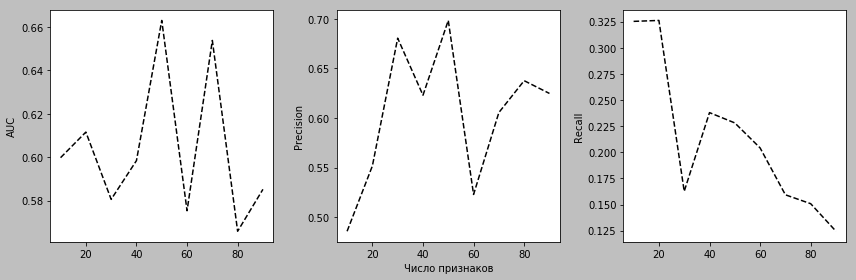

In [29]:
plt.figure(figsize=[12, 4])
plt.subplot(1, 3, 1)
plt.plot(feauture_range, [auc[i][1] for i in range(len(auc))], '--')
plt.ylabel('AUC')
plt.subplot(1, 3, 2)
plt.plot(feauture_range, [precision[i][1] for i in range(len(auc))], '--')
plt.xlabel('Число признаков')
plt.ylabel('Precision')
plt.subplot(1, 3, 3)
plt.plot(feauture_range, [recall[i][1] for i in range(len(recall))], '--')
plt.ylabel('Recall')
plt.tight_layout()